In [131]:
using SpiDy
using NPZ
using DataFrames
using CSV
using ProgressMeter
using Random
using Statistics
using LinearAlgebra
using Plots

########################
########################

Δt = 1
N = 200
tspan = (0., N*Δt)
saveat = (0:1:N)*Δt
α = 10.
ω0 = 7.
Γ = 5.
J = LorentzianSD(α, ω0, Γ) # coloring the noise
matrix = AnisoCoupling([-sin(π/4) 0. 0. # coupling to the environment
                        0. 0. 0.
                        cos(π/4) 0. 0.]);
T = .01
noise = ClassicalNoise(T);

nspin = 1 # number of spins

s0 = zeros(3*nspin)
for i in 1:nspin
    ϵ = 0.1
    s0tmp = [ϵ*rand(), ϵ*rand(), -1]
    s0[1+(i-1)*3:3+(i-1)*3] = s0tmp./norm(s0tmp)
end
J0 = 1.
JH = Nchain(nspin, J0)

nruns = 100000


100000

In [132]:
println("Starting...")
progress = Progress(nruns);

sols = zeros(nruns, length(saveat), 3*nspin)

Threads.@threads for i in 1:nruns
    bfields = [bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise),
               bfield(N, Δt, J, noise)];
    sol = diffeqsolver(s0, tspan, J, bfields, matrix; JH=JH, saveat=saveat);
    sols[i, :, :] = transpose(sol[:, :])
    next!(progress)
end

solavg = mean(sols, dims=1)[1, :, :];
solstd = std(sols, dims=1)[1, :, :];

Starting...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


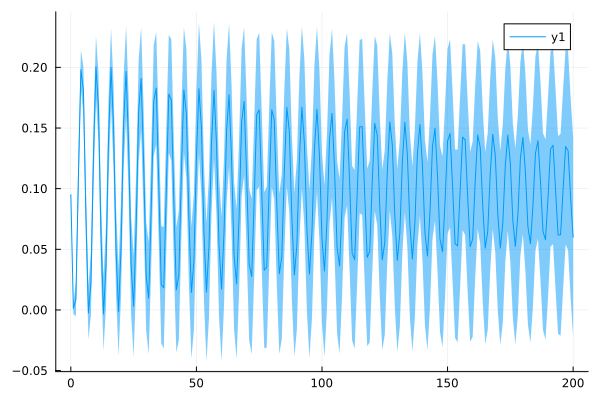

In [133]:
plot(saveat, solavg[:, 1], ribbon=solstd[:, 1])

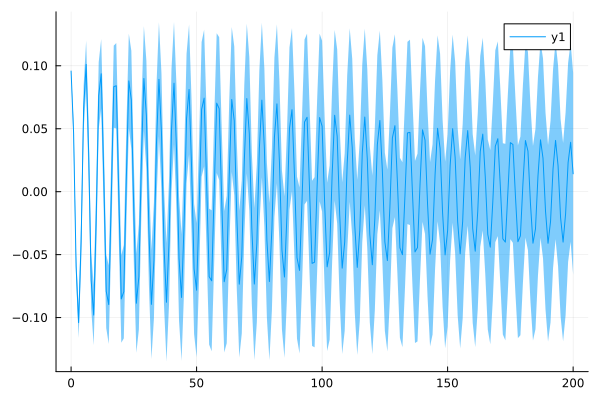

In [134]:
plot(saveat, solavg[:, 2], ribbon=solstd[:, 2])

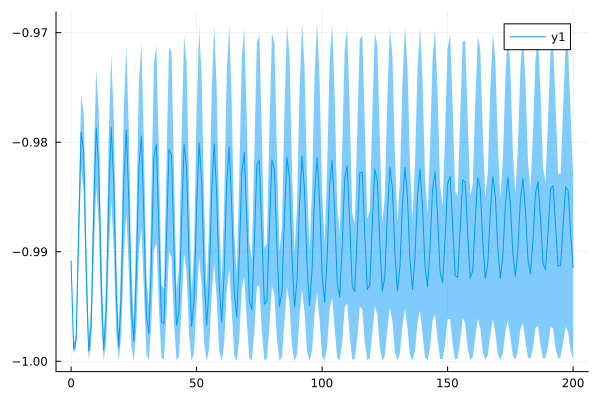

In [135]:
plot(saveat, solavg[:, 3], ribbon=solstd[:, 3])

In [136]:
projected = zeros(nruns, length(saveat), 2)

normalized_avg = eachrow(solavg) |> x -> normalize(x)

for i in 1:length(saveat)
    n = normalized_avg[i, :][1]

    u = normalize(cross(n, [0,0,1]))
    v = cross(u, n)

    for j in 1:nruns
        b = sols[j, i, :]
        proj = dot(b, n) * n
        b_ort = b - proj

        projected[j, i, 1] = dot(u,b)
        projected[j, i, 2] = dot(v,b)
    end
end

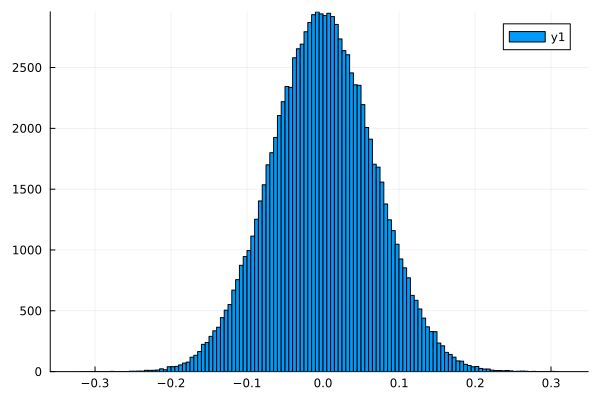

In [137]:
histogram(projected[:, 100, 1])

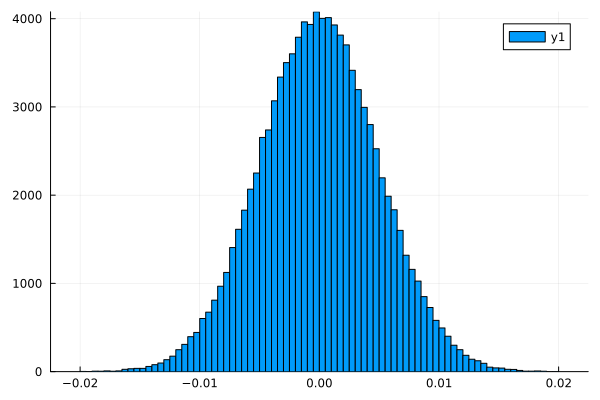

In [138]:
histogram(projected[:, 100, 2])

In [139]:
function nth_moment(data, N)
    return mean(data .^ N)
end

nth_moment (generic function with 1 method)

In [141]:
using HypothesisTests
HypothesisTests.JarqueBeraTest(projected[:, 100, 1])

Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "0.023546329936401093 and 3.0128495793233214"

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           0.0070

Details:
    number of observations:         100000
    JB statistic:                   9.92846
